# Introduction to Theano

To execute a cell: Ctrl-Enter.

The code was executed with the default configuration of Theano: `floatX=float64`, `device=cpu` and the configuration for GPU `floatX=float32,device=cuda`.

In [2]:
import os
#os.environ['THEANO_FLAGS'] = 'floatX=float64,device=cpu,mode=FAST_RUN'
os.environ['THEANO_FLAGS'] = 'floatX=float32, device=cuda, mode=FAST_RUN'

In [3]:
import numpy as np
import theano
import theano.tensor as T

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX TITAN Black (0000:03:00.0)


# Theano concepts

## Symbolic input

The symbolic inputs that you operate on are **Variables** and what you get from applying various **Ops** to these inputs are also Variables. A Variable is the main data structure you work with. A **Type** in Theano represents a set of constraints on potential data objects. These constraints allow Theano to tailor C code to handle them and to statically optimize the computation graph. The Type of both `x` and `y` is `matrix`. Here is [the complete list of types](http://deeplearning.net/software/theano/library/tensor/basic.html#all-fully-typed-constructors).

In [5]:
x = T.matrix('x')
y = T.matrix('y')

## Operation

An **Op** defines a certain computation on some types of inputs, producing some types of outputs. From a list of input Variables and an Op, you can build an **Apply** node representing the application of the Op to the inputs.

An Apply node is a type of internal node used to represent a computation graph.
It represents the application of an Op on one or more inputs, where each input is a Variable. By convention, each Op is responsible for knowing how to build an Apply node from a list of inputs.

In [6]:
z = x + y

![apply.png](http://deeplearning.net/software/theano/_images/apply.png)

## theano.function

`theano.function` is the interface for compiling graphs into callable objects. When `theano.function` is executed, the computation graph is optimized and theano generates an efficient code in C (with calls to CUDA if the gpu flag is set). This is totally transparent to the user, except for the different compilation modes.
The mode argument controls the sort of optimizations that will be applied to the graph, and the way the optimized graph will be evaluated. These modes are:
- `FAST_COMPILE`: Apply just a few graph optimizations and only use Python implementations. So GPU is disabled.

- `FAST_RUN`: Apply all optimizations and use C implementations where possible. (DEFAULT)

- `DebugMode`: Verify the correctness of all optimizations, and compare C and Python implementations. This mode can take much longer than the other modes, but can identify several kinds of problems.

The default is typically `FAST_RUN` but this can be changed in `theano.config.mode`.

In [8]:
# theano.function([inputs], [outputs])
f = theano.function([x, y], z, allow_input_downcast=True)

a = np.random.randn(1, 3) # float64 
b = np.random.randn(1, 3) # float64
f(a,b)

array([[-0.73415917,  1.32123518,  2.25580025]], dtype=float32)

## Shared variable

A **Shared Variable** is a hybrid symbolic and non-symbolic variable whose value may be shared between multiple functions. Shared variables can be used in symbolic expressions but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. The value can be accessed and modified by the .get_value() and .set_value() methods.

In [11]:
a = theano.shared(np.ones(3, dtype=theano.config.floatX), name = 'a')
print('Before ', a.get_value())
#a.set_value(1) #  Type error, must be a numpy array of shape (3,)
#a.set_value(np.array([[1,2],[3,4]])) # Type error, must be a numpy array of shape (3,)
#a.set_value(np.array([1,2,3]))
a.set_value(np.array([1,2,3],dtype=theano.config.floatX))
print('After ', a.get_value())

Before  [ 1.  1.  1.]
After  [ 1.  2.  3.]


### Shared variables and functions

Shared variables can be used to represent an internal state of a function. In order to modify this internal state, the function has an argument called `updates`, which takes an iterable over pairs (shared_variable, new_expression) List, tuple or dict.

Note in the following that `state` is an implicit input of the function `accumulator`.

In [12]:
state = theano.shared(0)
inc = T.iscalar('inc')
accumulator = theano.function([inc], state, updates=[(state, state+inc)])

The function is evaluated and then, the update mechanism is executed.

In [13]:
print('First call to accumulator {}:'.format(accumulator(1)))
print('Second call to accumulator {}:'.format(accumulator(10)))
print('Third call to accumulator {}:'.format(accumulator(100)))
print('Fourth call to accumulator {}:'.format(accumulator(100)))

First call to accumulator 0:
Second call to accumulator 1:
Third call to accumulator 11:
Fourth call to accumulator 111:


It may happen that you expressed some formula using a shared variable, but you do not want to use its value. In this case, you can use the givens parameter of function which replaces a particular node in a graph for the purpose of one particular function. The givens parameter can be used to replace any symbolic variable, not just a shared variable. You can replace constants, and expressions, in general. Be careful though, not to allow the expressions introduced by a givens substitution to be co-dependent, the order of substitution is not defined, so the substitutions have to work in any order.

In practice, a good way of thinking about the givens is as a mechanism that allows you to replace any part of your formula with a different expression that evaluates to a tensor of same shape and dtype. [[reference]](http://deeplearning.net/software/theano/tutorial/examples.html#basictutexamples)

In the following, we create a function that takes a scalar `foo`, replace temporarily the variable `state` and return its value.

In [15]:
foo = T.scalar(dtype=state.dtype)
accumulator2 = theano.function([foo], state, givens=[(state, foo)])
print(accumulator2(1))
print(state.get_value())  # old state still there, but we didn't use it

1
211


# A regression toy example
## Build a simple model
The following is a simple linear transformation (out = Wx +b) followed by a nonlinearity (theano.sigmoid). Note that in this example, we are using `allow_input_downcast=True` in order to avoid an error associated to downcasting x_val from a `float64` to a `float32`. Without this parameter, `x_val` must be casted explicitly: `x_val = np.random.rand(4).astype(np.float32)`.

In [16]:
x = T.vector('x')
W = theano.shared(np.random.randn(3, 4).astype(theano.config.floatX), name = 'W')
b = theano.shared(np.ones(3, dtype=theano.config.floatX), name = 'b')

dot = T.dot(W, x)
out = T.nnet.sigmoid(dot + b)

predict = theano.function([x], out, allow_input_downcast=True)
x_val = np.random.rand(4)
print(predict(x_val))

[ 0.79911566  0.45530102  0.64830917]


In order to train the model, we define a cost function that will evaluate how far the model is from the target.

In [17]:
y = T.vector('y')
C = ((out - y) ** 2).mean()
C.name = 'C'
error = theano.function([out, y], C, allow_input_downcast=True)

y_val = np.random.uniform(size=3).astype(theano.config.floatX)
print(error([ 0.66981461,  0.60965314,  0.76731602], y_val))

0.059905216097831726


## Automatic differentiation

Now that the graph is defined, we can compute the gradient of the cost C w.r.t some parameters (W,b). The gradient must be applied to a scalar expression, e.g., the cost C.

In [18]:
# theano.grad(exp, [Variable])
dC_dW, dC_db = theano.grad(C, [W, b])

Now that we can compute the gradients, we define the gradient descent update rule.

In [19]:
eta_val = np.array(0.1, dtype=theano.config.floatX)
eta = theano.shared(eta_val, name='eta')
upd_W = W - eta * dC_dW
upd_b = b - eta * dC_db

Finally, we compile the expressions and the update rules.

In [20]:
train = theano.function([x, y], C, updates=[(W, upd_W), (b, upd_b)], allow_input_downcast=True)
#train = theano.function([x, y], C, updates=[(W, upd_W), (b, upd_b)], allow_input_downcast=True)
#print(b.get_value())
#print(W.get_value())

We iterate the gradient descent update rule in order to minimize the cost.

In [21]:
for i in range(50):
    C_val = train(x_val, y_val)
    print('Cost {:} at iteration {}'.format(C_val,i))
print(b.get_value())
print(W.get_value())

Cost 0.056426048278808594 at iteration 0
Cost 0.05591142550110817 at iteration 1
Cost 0.055402517318725586 at iteration 2
Cost 0.05489925667643547 at iteration 3
Cost 0.05440157279372215 at iteration 4
Cost 0.05390937626361847 at iteration 5
Cost 0.053422629833221436 at iteration 6
Cost 0.05294123291969299 at iteration 7
Cost 0.052465129643678665 at iteration 8
Cost 0.05199423432350159 at iteration 9
Cost 0.051528483629226685 at iteration 10
Cost 0.05106781795620918 at iteration 11
Cost 0.05061216652393341 at iteration 12
Cost 0.05016147717833519 at iteration 13
Cost 0.049715664237737656 at iteration 14
Cost 0.04927465319633484 at iteration 15
Cost 0.04883842542767525 at iteration 16
Cost 0.04840688034892082 at iteration 17
Cost 0.04797996208071709 at iteration 18
Cost 0.04755761846899986 at iteration 19
Cost 0.04713977873325348 at iteration 20
Cost 0.046726394444704056 at iteration 21
Cost 0.04631741717457771 at iteration 22
Cost 0.045912761241197586 at iteration 23
Cost 0.04551238939

# Visualization and debugging
## Graph visualization
### Comparing `out` with `predict`

In [22]:
from theano.printing import pydotprint
from IPython.display import Image, SVG

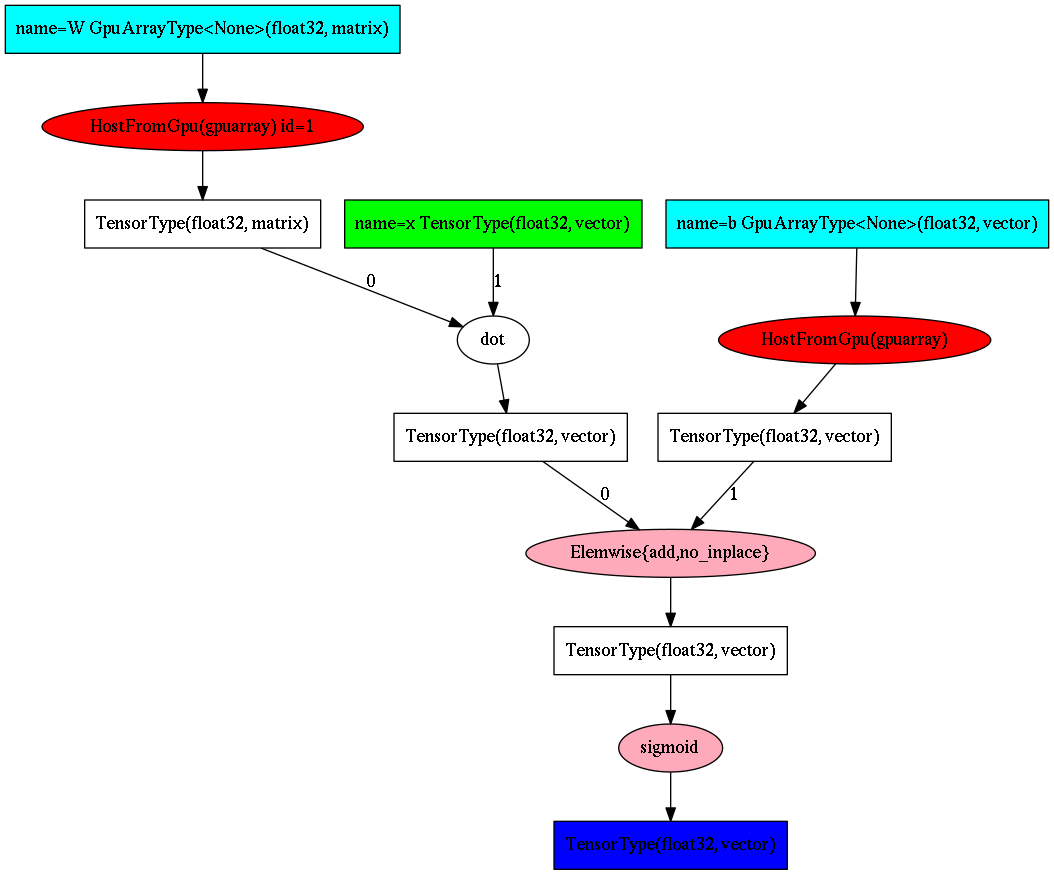

In [23]:
Image(pydotprint(out, format='png', compact=False, return_image=True))

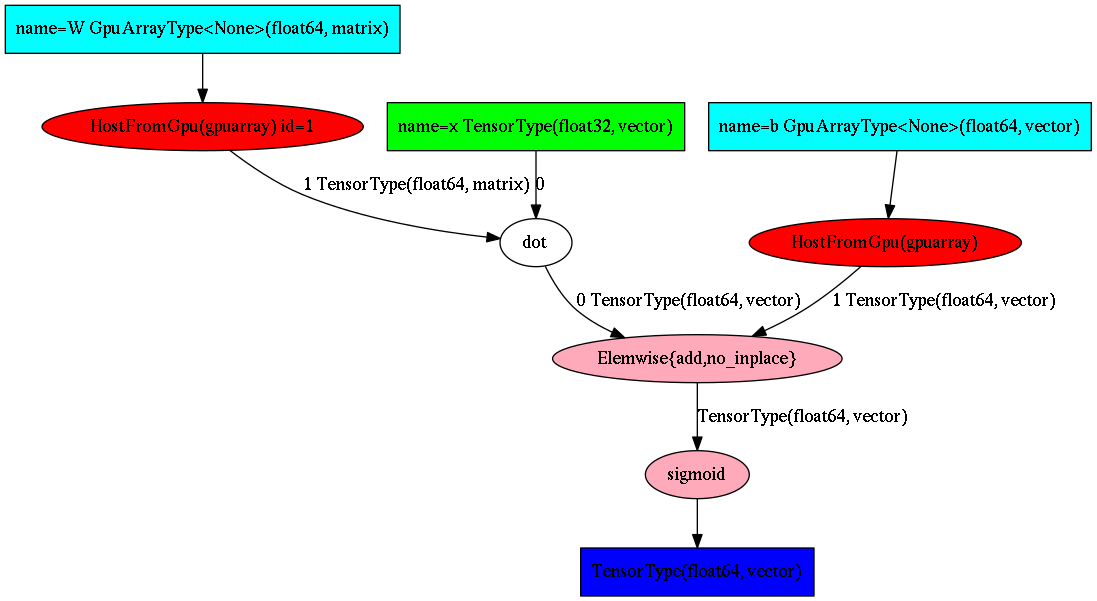

In [27]:
Image(pydotprint(out, format='png', return_image=True))

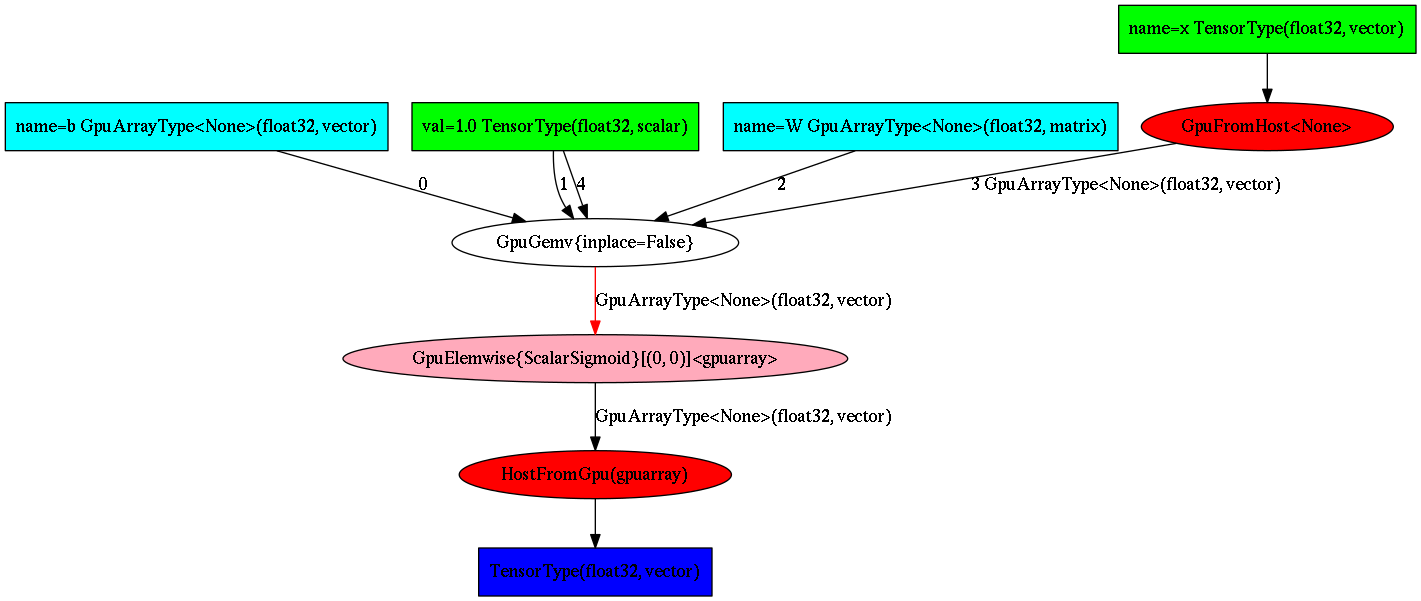

In [24]:
Image(pydotprint(predict, format='png', return_image=True))

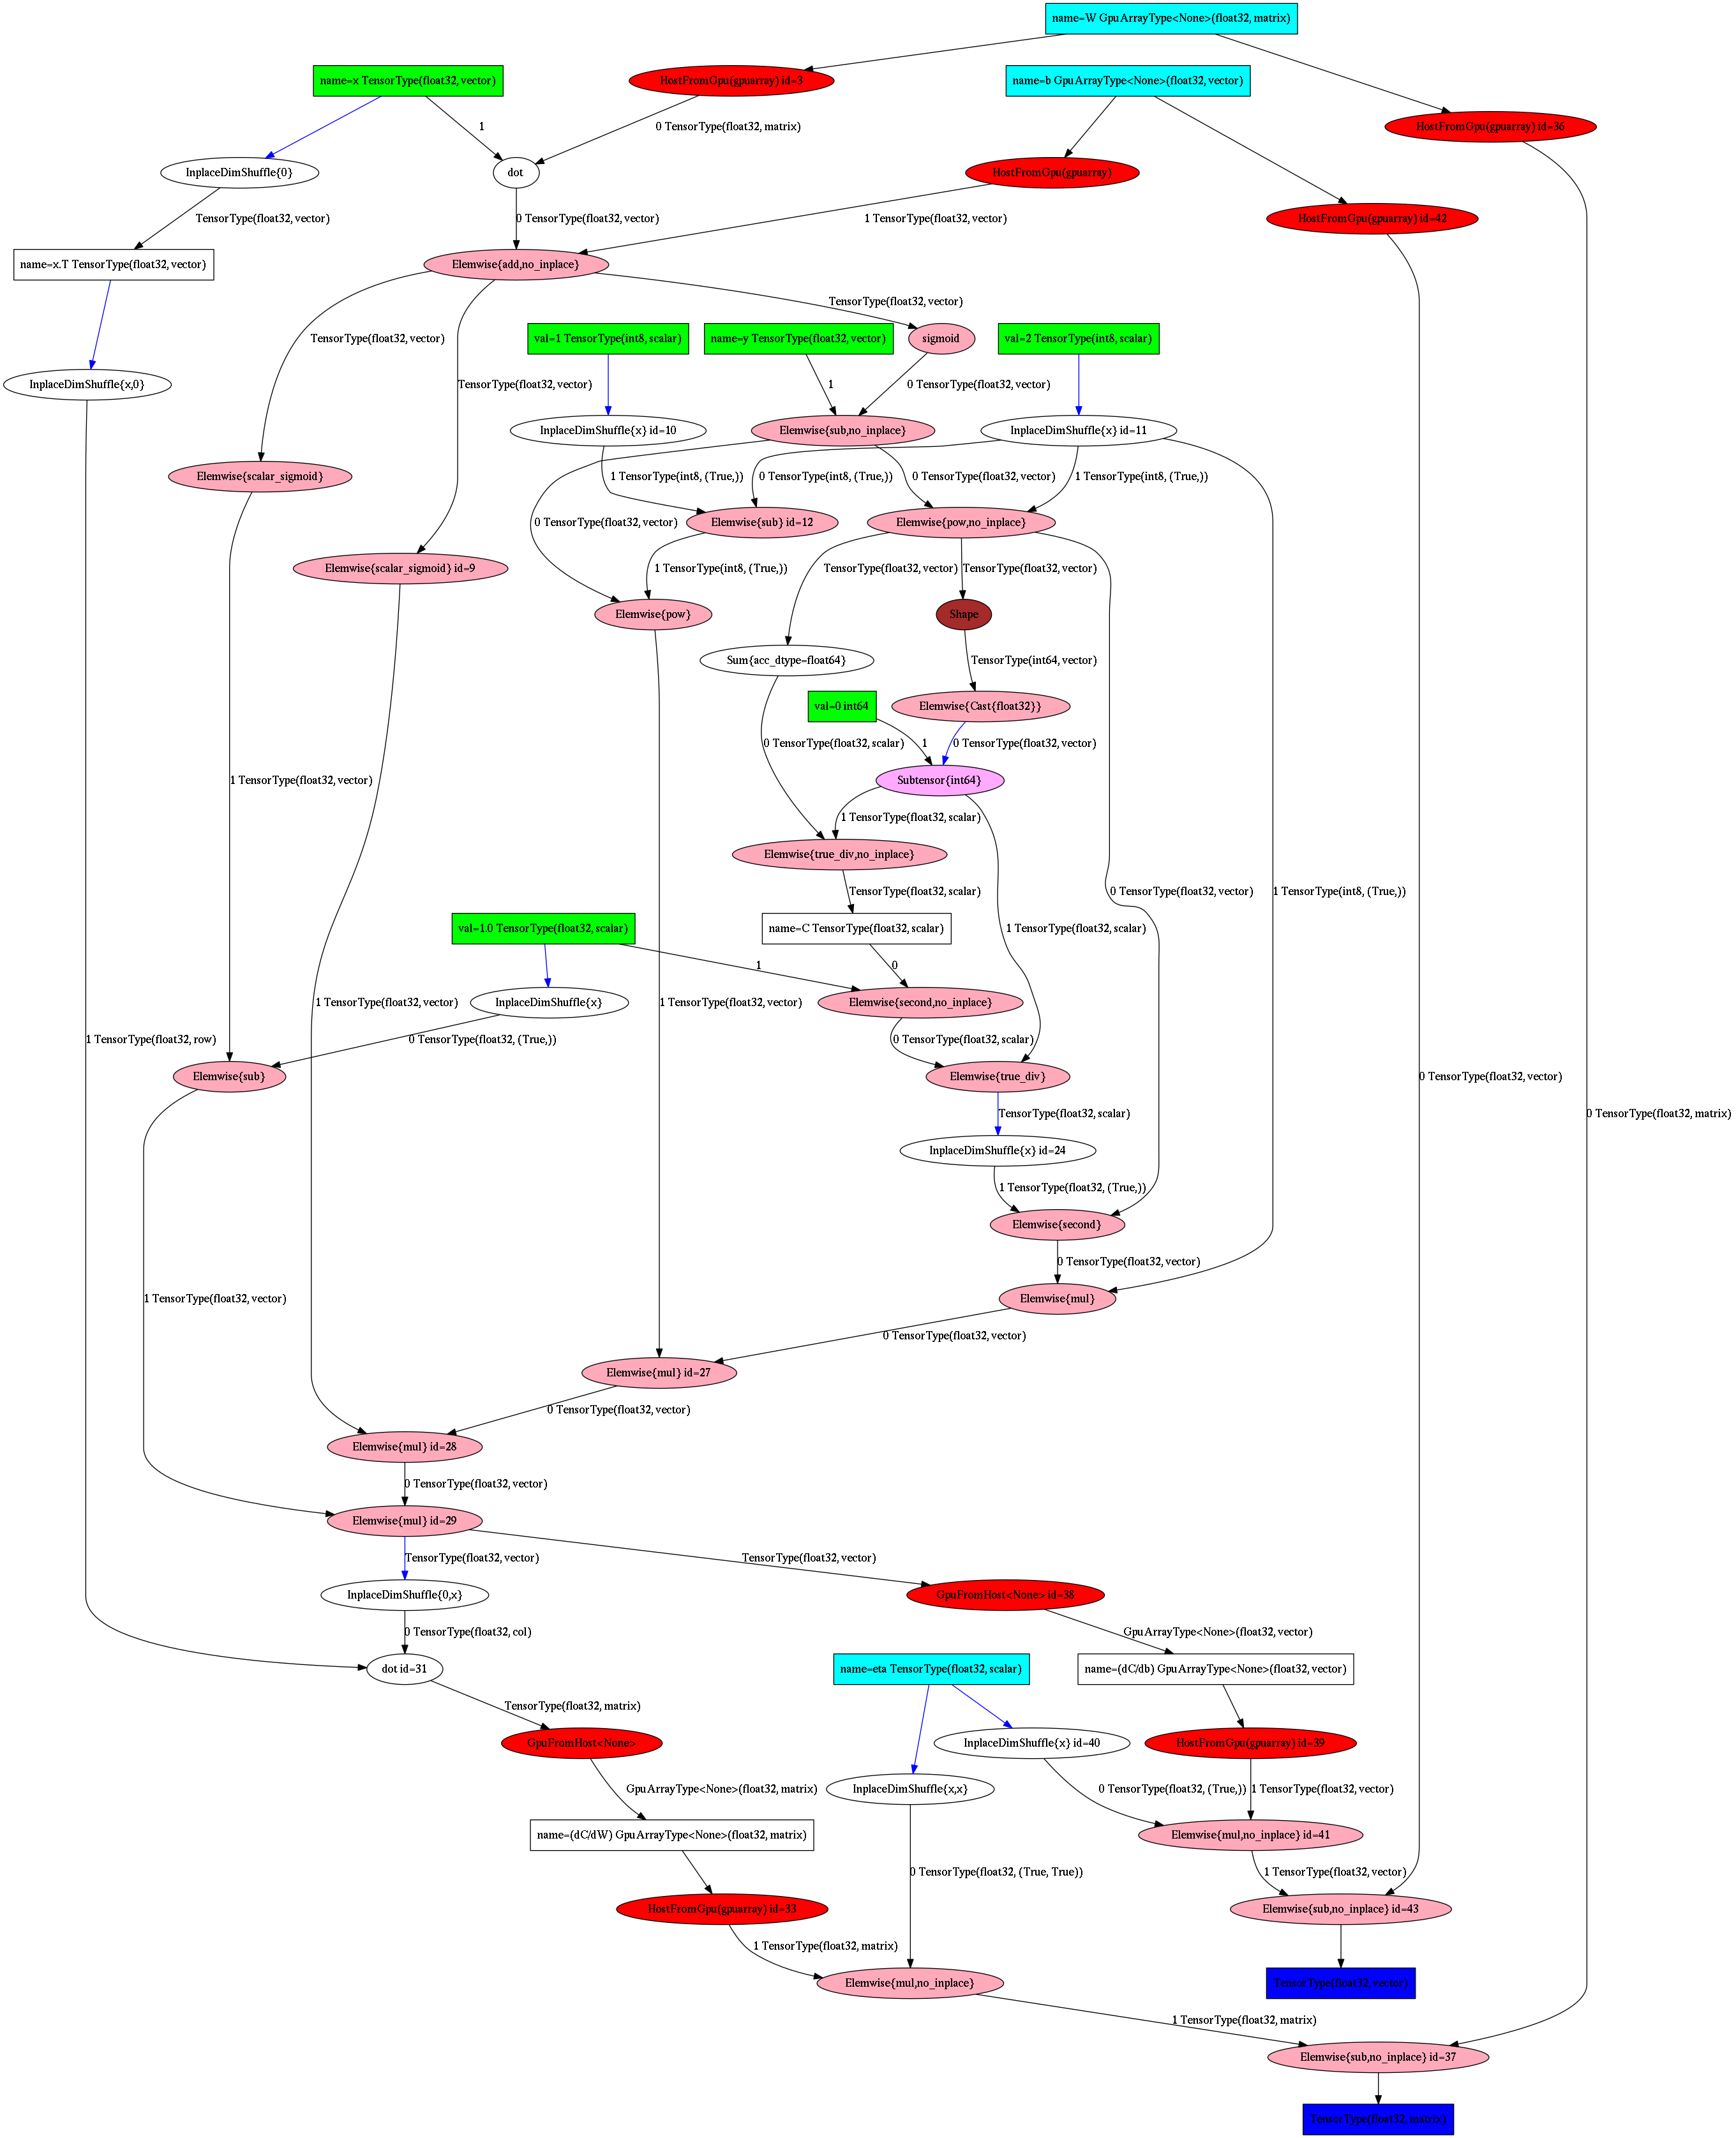

In [25]:
Image(pydotprint([upd_W, upd_b], format='png', return_image=True), width=1000)

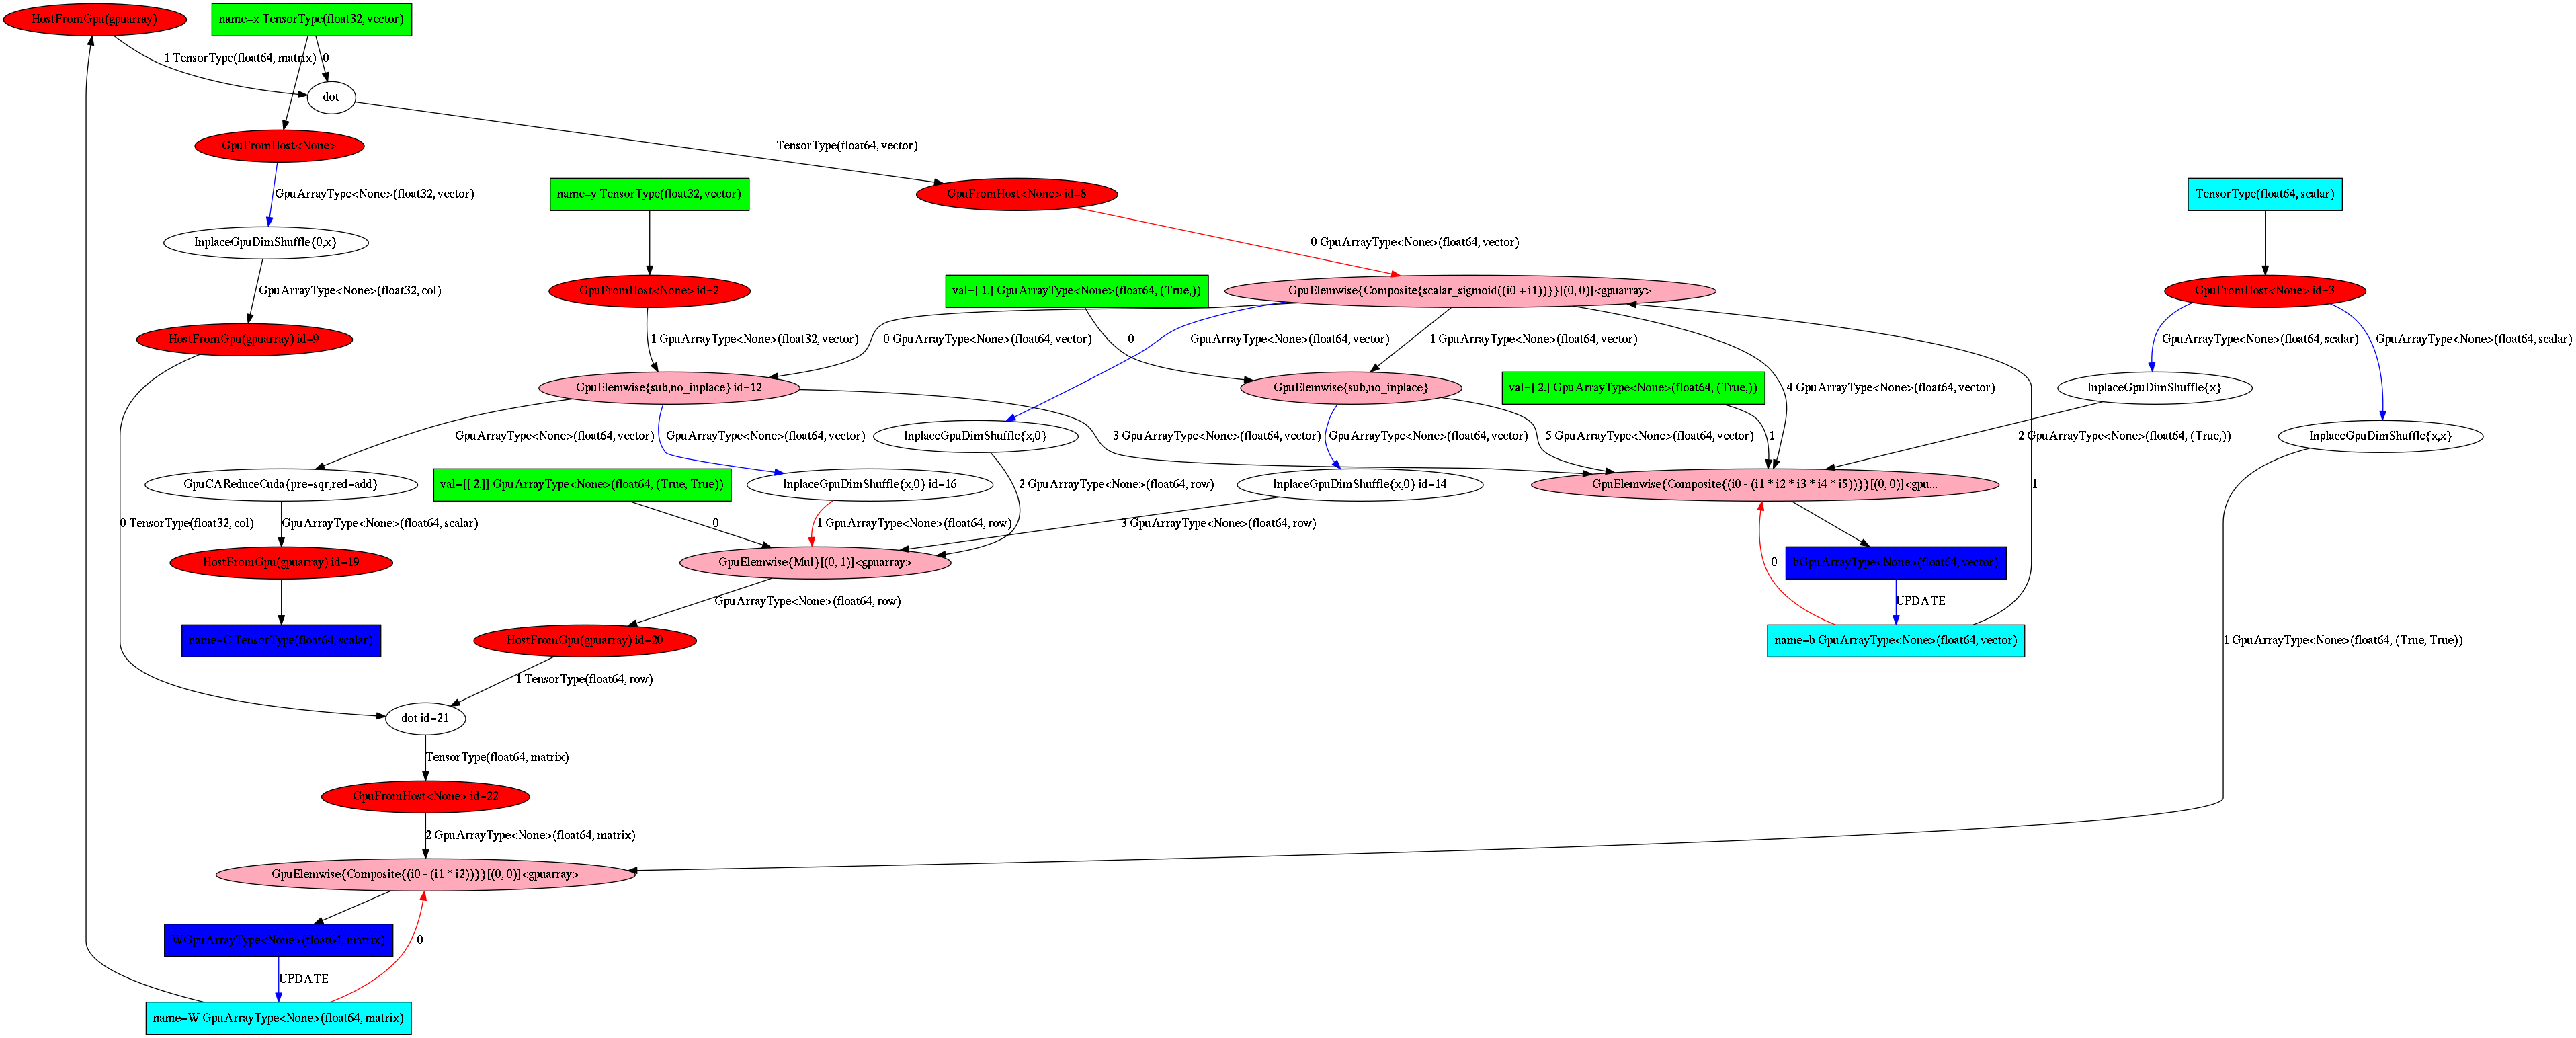

In [30]:
Image(pydotprint(train, format='png', return_image=True), width=1000)

In [26]:
from theano.printing import debugprint
debugprint(out)
debugprint(predict)

sigmoid [id A] ''   
 |Elemwise{add,no_inplace} [id B] ''   
   |dot [id C] ''   
   | |HostFromGpu(gpuarray) [id D] ''   
   | | |W [id E]
   | |x [id F]
   |HostFromGpu(gpuarray) [id G] ''   
     |b [id H]
HostFromGpu(gpuarray) [id A] ''   3
 |GpuElemwise{ScalarSigmoid}[(0, 0)]<gpuarray> [id B] ''   2
   |GpuGemv{inplace=False} [id C] ''   1
     |b [id D]
     |TensorConstant{1.0} [id E]
     |W [id F]
     |GpuFromHost<None> [id G] ''   0
     | |x [id H]
     |TensorConstant{1.0} [id E]


# Computation graph and loop

Let `A` be a tensor and `k` a positive integer, we are interested by computing `A.^k` (element-wise power). This computation involves a for loop that iterates `k` times. To define the associated computation graph, we use the `scan` function. The arguments of the `scan` function are the:
- fn: a Theano function representing the computation that is done in a single iteration of the loop represented by the scan op. Note that **the order of parameters is fixed by** `scan`: the output of the prior call to `fn` is the first parameter, followed by all non-sequences,
- output_info: initial value of the output variable,
- sequence: A sequence is a Theano variable which Scan will iterate over and give sub-elements to its inner function as input. A sequence has no associated output. For a sequence variable X, at timestep t, the inner function will receive as input the sequence element X[t],
- non_sequences: A non-sequence is a Theano variable which Scan will provide as-is to its inner function. Like a sequence, a non-sequence has no associated output. For a non-sequence variable X, at timestep t, the inner function will receive as input the variable X,
- n_steps: number of iteration

Then, `scan` returns a tuple containing our result and a dictionary of updates (empty in the following case).

In [ ]:
k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)

print(power(range(10),2))
print(power(range(10),4))

With scan, it is important to distinguish the following types of output variables (tap refers to time slices of sequences or outputs):
- Nitsot (no input tap, single output tap) : A nitsot is an output variable of the inner function that is not fed back as an input to the next iteration of the inner function. Nitsots are typically encountered in situations where Scan is used to perform a ‘map’ operation (every element in a tensor is independently altered using a given operation to produce a new tensor) such as squaring every number in a vector,
- Sitsot (single input tap, single output tap) : A sitsot is an output variable of the inner function that is fed back as an input to the next iteration of the inner function. A typical setting where a sitsot might be encountered is the case where Scan is used to compute the cumulative sum over the elements of a vector and a sitsot output is employed to act as an accumulator,
- Mitsot (multiple input taps, single output tap) : A mitsot is an output variable of the inner function that is fed back as an input to future iterations of the inner function (either multiple future iterations or a single one that isn’t the immediate next one). For example, a mitsot might be used in the case where Scan is used to compute the Fibonacci sequence, one term of the sequence at every timestep, since every computed term needs to be reused to compute the two next terms of the sequence,
- Mitmot (multiple input taps, multiple output taps) : These outputs exist but they cannot be directly created by the user. They can appear in a theano graph as a result of taking the gradient of the output of a Scan with respect to its inputs: This will result in the creation of a new scan node used to compute the gradients of the first scan node. If the original Scan had sitsots or mitsots variables, the new Scan will use mitmots to compute the gradients through time for these variables.

The first three types can be used by the user, while the last one is only used internally for computing the gradient through `scan`.

In the next example, we calculate the polynomial by first generating each of the coefficients, and then summing them at the end. There is no accumulation of results so we can set `outputs_info` to `None`. This indicates to scan that it doesn’t need to pass the prior result to `fn`.

The general order of function parameters to fn is:
- sequences (if any),
- prior result(s) (if needed), 
- non-sequences (if any).


In [ ]:
coefficients = theano.tensor.vector("coefficients")
x = T.scalar("x")

max_coefficients_supported = 10000

# Generate the components of the polynomial
components, updates = theano.scan(fn=lambda coefficient, power, free_variable: coefficient * (free_variable ** power),
                                  outputs_info=None,
                                  sequences=[coefficients, theano.tensor.arange(max_coefficients_supported)],
                                  non_sequences=x)
# Sum them up
polynomial = components.sum()

# Compile a function
calculate_polynomial = theano.function(inputs=[coefficients, x], outputs=polynomial)

# Test
test_coefficients = np.asarray([1, 0, 2], dtype=np.float32)
test_value = 3
print(calculate_polynomial(test_coefficients, test_value))
print(1.0 * (3 ** 0) + 0.0 * (3 ** 1) + 2.0 * (3 ** 2))

For additional information about `scan`, please refer to [theano doc](http://deeplearning.net/software/theano/library/scan.html).